In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 110 + 1 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
# beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
# b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
# bb_imp = np.zeros((n_alpha*n_beta,1))

# for j in range(n_beta):
#     b_imp = b_ * beta[j]
#     bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
# bb_imp = bb_imp.reshape((-1,1))

# bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
# bb = bb / np.max(beta)
    
# print(bb.shape)

In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

# hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
# hh = hh.reshape((-1,1))

In [12]:
# hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
# x = np.hstack((aa, hh, bb, total_coords))
x = np.hstack((aa, total_coords))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [25]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [26]:
y.shape

(144, 2)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [28]:
x_train.shape

(100, 111)

In [29]:
y_train.shape

(100, 2)

In [30]:
tf.keras.backend.set_image_data_format('channels_last')

In [31]:
input_data = tf.keras.Input(shape=(input_size))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 111)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14336     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 128)               16512     
                                                                 
 outputLayer (Dense)         (None, 2)                 258   

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
model_directory = "D:\\TrainedModels\\20221124"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)

In [35]:
## Setting up callbacks
checkpoint_name = model_directory + '\\20221124ModelCheckpoint_MLP_test'+str(test_rate)+'_coordinatesOnly.h5'
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
ckpt = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, save_best_only=True,
                                          monitor='loss', mode='min')
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=200, factor=0.5,
                                          min_delta = 1e-08, min_lr=1e-08,
                                          verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=10000, callbacks=[es, ckpt,rp])
end = datetime.datetime.now()

Epoch 1/10000
5/5 [==============================] - 1s 12ms/step - loss: 0.6537 - rmse: 0.8085 - lr: 0.0010
Epoch 2/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.2510 - rmse: 0.5010 - lr: 0.0010
Epoch 3/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.1511 - rmse: 0.3887 - lr: 0.0010
Epoch 4/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.0706 - rmse: 0.2657 - lr: 0.0010
Epoch 5/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0834 - rmse: 0.2888 - lr: 0.0010
Epoch 6/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.0410 - rmse: 0.2025 - lr: 0.0010
Epoch 7/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.0382 - rmse: 0.1954 - lr: 0.0010
Epoch 8/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.0273 - rmse: 0.1651 - lr: 0.0010
Epoch 9/10000
5/5 [==============================] - 0s 18ms/step - loss: 0.0250 - rmse: 0.1581 - lr: 0.0010
Epoch 10/10000
5/5 [

5/5 [==============================] - 0s 3ms/step - loss: 0.0187 - rmse: 0.1369 - lr: 0.0010
Epoch 77/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0202 - rmse: 0.1420 - lr: 0.0010
Epoch 78/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0192 - rmse: 0.1385 - lr: 0.0010
Epoch 79/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0182 - rmse: 0.1348 - lr: 0.0010
Epoch 80/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0187 - rmse: 0.1366 - lr: 0.0010
Epoch 81/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0188 - rmse: 0.1372 - lr: 0.0010
Epoch 82/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0187 - rmse: 0.1368 - lr: 0.0010
Epoch 83/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0188 - rmse: 0.1371 - lr: 0.0010
Epoch 84/10000
5/5 [==============================] - 0s 3ms/step - loss: 0.0180 - rmse: 0.1342 - lr: 0.0010
Epoch 85/10000
5/5 [==============

5/5 [==============================] - 0s 4ms/step - loss: 0.0188 - rmse: 0.1370 - lr: 0.0010
Epoch 151/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0183 - rmse: 0.1352 - lr: 0.0010
Epoch 152/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0181 - rmse: 0.1346 - lr: 0.0010
Epoch 153/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0184 - rmse: 0.1356 - lr: 0.0010
Epoch 154/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0184 - rmse: 0.1355 - lr: 0.0010
Epoch 155/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0190 - rmse: 0.1379 - lr: 0.0010
Epoch 156/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0199 - rmse: 0.1411 - lr: 0.0010
Epoch 157/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0185 - rmse: 0.1360 - lr: 0.0010
Epoch 158/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0182 - rmse: 0.1350 - lr: 0.0010
Epoch 159/10000
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0183 - rmse: 0.1354 - lr: 0.0010
Epoch 225/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0180 - rmse: 0.1341 - lr: 0.0010
Epoch 226/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0190 - rmse: 0.1380 - lr: 0.0010
Epoch 227/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0180 - rmse: 0.1343 - lr: 0.0010
Epoch 228/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0185 - rmse: 0.1360 - lr: 0.0010
Epoch 229/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0178 - rmse: 0.1334 - lr: 0.0010
Epoch 230/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0176 - rmse: 0.1327 - lr: 0.0010
Epoch 231/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0178 - rmse: 0.1336 - lr: 0.0010
Epoch 232/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0178 - rmse: 0.1335 - lr: 0.0010
Epoch 233/10000
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0175 - rmse: 0.1324 - lr: 0.0010
Epoch 299/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0182 - rmse: 0.1349 - lr: 0.0010
Epoch 300/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0185 - rmse: 0.1361 - lr: 0.0010
Epoch 301/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0178 - rmse: 0.1332 - lr: 0.0010
Epoch 302/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0177 - rmse: 0.1332 - lr: 0.0010
Epoch 303/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0178 - rmse: 0.1336 - lr: 0.0010
Epoch 304/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0188 - rmse: 0.1372 - lr: 0.0010
Epoch 305/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0194 - rmse: 0.1392 - lr: 0.0010
Epoch 306/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0180 - rmse: 0.1342 - lr: 0.0010
Epoch 307/10000
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0184 - rmse: 0.1358 - lr: 0.0010
Epoch 373/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0176 - rmse: 0.1326 - lr: 0.0010
Epoch 374/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0176 - rmse: 0.1328 - lr: 0.0010
Epoch 375/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0177 - rmse: 0.1330 - lr: 0.0010
Epoch 376/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0179 - rmse: 0.1339 - lr: 0.0010
Epoch 377/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0174 - rmse: 0.1318 - lr: 0.0010
Epoch 378/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0172 - rmse: 0.1313 - lr: 0.0010
Epoch 379/10000
5/5 [==============================] - 0s 24ms/step - loss: 0.0166 - rmse: 0.1289 - lr: 0.0010
Epoch 380/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0168 - rmse: 0.1297 - lr: 0.0010
Epoch 381/10000
5/5 [====

5/5 [==============================] - 0s 5ms/step - loss: 0.0210 - rmse: 0.1448 - lr: 0.0010
Epoch 447/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0229 - rmse: 0.1512 - lr: 0.0010
Epoch 448/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0210 - rmse: 0.1449 - lr: 0.0010
Epoch 449/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0185 - rmse: 0.1359 - lr: 0.0010
Epoch 450/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0173 - rmse: 0.1315 - lr: 0.0010
Epoch 451/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0160 - rmse: 0.1267 - lr: 0.0010
Epoch 452/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0173 - rmse: 0.1313 - lr: 0.0010
Epoch 453/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0171 - rmse: 0.1308 - lr: 0.0010
Epoch 454/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0167 - rmse: 0.1291 - lr: 0.0010
Epoch 455/10000
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0170 - rmse: 0.1303 - lr: 0.0010
Epoch 521/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0175 - rmse: 0.1324 - lr: 0.0010
Epoch 522/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0173 - rmse: 0.1317 - lr: 0.0010
Epoch 523/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0190 - rmse: 0.1379 - lr: 0.0010
Epoch 524/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0162 - rmse: 0.1274 - lr: 0.0010
Epoch 525/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0167 - rmse: 0.1292 - lr: 0.0010
Epoch 526/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0186 - rmse: 0.1364 - lr: 0.0010
Epoch 527/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0174 - rmse: 0.1321 - lr: 0.0010
Epoch 528/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0174 - rmse: 0.1319 - lr: 0.0010
Epoch 529/10000
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0151 - rmse: 0.1231 - lr: 0.0010
Epoch 595/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0156 - rmse: 0.1250 - lr: 0.0010
Epoch 596/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0154 - rmse: 0.1240 - lr: 0.0010
Epoch 597/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0159 - rmse: 0.1260 - lr: 0.0010
Epoch 598/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0157 - rmse: 0.1251 - lr: 0.0010
Epoch 599/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0155 - rmse: 0.1247 - lr: 0.0010
Epoch 600/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0158 - rmse: 0.1258 - lr: 0.0010
Epoch 601/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0154 - rmse: 0.1241 - lr: 0.0010
Epoch 602/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0155 - rmse: 0.1245 - lr: 0.0010
Epoch 603/10000
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0153 - rmse: 0.1235 - lr: 0.0010
Epoch 669/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0155 - rmse: 0.1247 - lr: 0.0010
Epoch 670/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0157 - rmse: 0.1254 - lr: 0.0010
Epoch 671/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0159 - rmse: 0.1260 - lr: 0.0010
Epoch 672/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0152 - rmse: 0.1233 - lr: 0.0010
Epoch 673/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0158 - rmse: 0.1258 - lr: 0.0010
Epoch 674/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0153 - rmse: 0.1237 - lr: 0.0010
Epoch 675/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0165 - rmse: 0.1286 - lr: 0.0010
Epoch 676/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0148 - rmse: 0.1218 - lr: 0.0010
Epoch 677/10000
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0149 - rmse: 0.1219 - lr: 0.0010
Epoch 743/10000
5/5 [==============================] - 0s 20ms/step - loss: 0.0143 - rmse: 0.1196 - lr: 0.0010
Epoch 744/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0151 - rmse: 0.1229 - lr: 0.0010
Epoch 745/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0160 - rmse: 0.1265 - lr: 0.0010
Epoch 746/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0178 - rmse: 0.1334 - lr: 0.0010
Epoch 747/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0172 - rmse: 0.1312 - lr: 0.0010
Epoch 748/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0155 - rmse: 0.1247 - lr: 0.0010
Epoch 749/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0166 - rmse: 0.1290 - lr: 0.0010
Epoch 750/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0156 - rmse: 0.1251 - lr: 0.0010
Epoch 751/10000
5/5 [====

5/5 [==============================] - 0s 5ms/step - loss: 0.0154 - rmse: 0.1240 - lr: 0.0010
Epoch 817/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0153 - rmse: 0.1239 - lr: 0.0010
Epoch 818/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0153 - rmse: 0.1236 - lr: 0.0010
Epoch 819/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0155 - rmse: 0.1244 - lr: 0.0010
Epoch 820/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0148 - rmse: 0.1215 - lr: 0.0010
Epoch 821/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0174 - rmse: 0.1320 - lr: 0.0010
Epoch 822/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0148 - rmse: 0.1215 - lr: 0.0010
Epoch 823/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0143 - rmse: 0.1197 - lr: 0.0010
Epoch 824/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0139 - rmse: 0.1180 - lr: 0.0010
Epoch 825/10000
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0157 - rmse: 0.1252 - lr: 0.0010
Epoch 891/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0144 - rmse: 0.1202 - lr: 0.0010
Epoch 892/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0137 - rmse: 0.1172 - lr: 0.0010
Epoch 893/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0134 - rmse: 0.1159 - lr: 0.0010
Epoch 894/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0133 - rmse: 0.1151 - lr: 0.0010
Epoch 895/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0133 - rmse: 0.1152 - lr: 0.0010
Epoch 896/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0135 - rmse: 0.1164 - lr: 0.0010
Epoch 897/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0132 - rmse: 0.1148 - lr: 0.0010
Epoch 898/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0134 - rmse: 0.1157 - lr: 0.0010
Epoch 899/10000
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0129 - rmse: 0.1135 - lr: 0.0010
Epoch 965/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0130 - rmse: 0.1140 - lr: 0.0010
Epoch 966/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0143 - rmse: 0.1197 - lr: 0.0010
Epoch 967/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0138 - rmse: 0.1173 - lr: 0.0010
Epoch 968/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0130 - rmse: 0.1141 - lr: 0.0010
Epoch 969/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0133 - rmse: 0.1151 - lr: 0.0010
Epoch 970/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0129 - rmse: 0.1138 - lr: 0.0010
Epoch 971/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0128 - rmse: 0.1133 - lr: 0.0010
Epoch 972/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0128 - rmse: 0.1130 - lr: 0.0010
Epoch 973/10000
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0125 - rmse: 0.1118 - lr: 0.0010
Epoch 1039/10000
5/5 [==============================] - 0s 28ms/step - loss: 0.0117 - rmse: 0.1081 - lr: 0.0010
Epoch 1040/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0124 - rmse: 0.1115 - lr: 0.0010
Epoch 1041/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0137 - rmse: 0.1169 - lr: 0.0010
Epoch 1042/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0155 - rmse: 0.1246 - lr: 0.0010
Epoch 1043/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0160 - rmse: 0.1263 - lr: 0.0010
Epoch 1044/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0159 - rmse: 0.1260 - lr: 0.0010
Epoch 1045/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0136 - rmse: 0.1164 - lr: 0.0010
Epoch 1046/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0137 - rmse: 0.1169 - lr: 0.0010
Epoch 1047/10000


Epoch 1112/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0124 - rmse: 0.1112 - lr: 0.0010
Epoch 1113/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0121 - rmse: 0.1102 - lr: 0.0010
Epoch 1114/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0123 - rmse: 0.1108 - lr: 0.0010
Epoch 1115/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0129 - rmse: 0.1137 - lr: 0.0010
Epoch 1116/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0129 - rmse: 0.1134 - lr: 0.0010
Epoch 1117/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0138 - rmse: 0.1174 - lr: 0.0010
Epoch 1118/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0142 - rmse: 0.1192 - lr: 0.0010
Epoch 1119/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0128 - rmse: 0.1133 - lr: 0.0010
Epoch 1120/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0135 - rmse: 0.1164 - lr: 0.0010
E

5/5 [==============================] - 0s 5ms/step - loss: 0.0119 - rmse: 0.1089 - lr: 0.0010
Epoch 1186/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0119 - rmse: 0.1090 - lr: 0.0010
Epoch 1187/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0128 - rmse: 0.1131 - lr: 0.0010
Epoch 1188/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0121 - rmse: 0.1098 - lr: 0.0010
Epoch 1189/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0117 - rmse: 0.1084 - lr: 0.0010
Epoch 1190/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0132 - rmse: 0.1150 - lr: 0.0010
Epoch 1191/10000
5/5 [==============================] - 0s 37ms/step - loss: 0.0113 - rmse: 0.1065 - lr: 0.0010
Epoch 1192/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0122 - rmse: 0.1103 - lr: 0.0010
Epoch 1193/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0122 - rmse: 0.1105 - lr: 0.0010
Epoch 1194/10000


Epoch 1259/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0121 - rmse: 0.1100 - lr: 0.0010
Epoch 1260/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0122 - rmse: 0.1104 - lr: 0.0010
Epoch 1261/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0120 - rmse: 0.1094 - lr: 0.0010
Epoch 1262/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0119 - rmse: 0.1092 - lr: 0.0010
Epoch 1263/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0118 - rmse: 0.1088 - lr: 0.0010
Epoch 1264/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0124 - rmse: 0.1113 - lr: 0.0010
Epoch 1265/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1075 - lr: 0.0010
Epoch 1266/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1077 - lr: 0.0010
Epoch 1267/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0119 - rmse: 0.1090 - lr: 0.0010
E

5/5 [==============================] - 0s 5ms/step - loss: 0.0127 - rmse: 0.1125 - lr: 0.0010
Epoch 1333/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0124 - rmse: 0.1115 - lr: 0.0010
Epoch 1334/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0123 - rmse: 0.1108 - lr: 0.0010
Epoch 1335/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0115 - rmse: 0.1075 - lr: 0.0010
Epoch 1336/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1079 - lr: 0.0010
Epoch 1337/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0118 - rmse: 0.1089 - lr: 0.0010
Epoch 1338/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0118 - rmse: 0.1085 - lr: 0.0010
Epoch 1339/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0114 - rmse: 0.1066 - lr: 0.0010
Epoch 1340/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0115 - rmse: 0.1072 - lr: 0.0010
Epoch 1341/10000
5

Epoch 1406/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0128 - rmse: 0.1130 - lr: 0.0010
Epoch 1407/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0120 - rmse: 0.1095 - lr: 0.0010
Epoch 1408/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0118 - rmse: 0.1086 - lr: 0.0010
Epoch 1409/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1079 - lr: 0.0010
Epoch 1410/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0113 - rmse: 0.1063 - lr: 0.0010
Epoch 1411/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0112 - rmse: 0.1060 - lr: 0.0010
Epoch 1412/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0120 - rmse: 0.1094 - lr: 0.0010
Epoch 1413/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0112 - rmse: 0.1059 - lr: 0.0010
Epoch 1414/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0129 - rmse: 0.1134 - lr: 0.0010
E

5/5 [==============================] - 0s 5ms/step - loss: 0.0124 - rmse: 0.1114 - lr: 0.0010
Epoch 1480/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0109 - rmse: 0.1044 - lr: 0.0010
Epoch 1481/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0118 - rmse: 0.1085 - lr: 0.0010
Epoch 1482/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0111 - rmse: 0.1052 - lr: 0.0010
Epoch 1483/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1079 - lr: 0.0010
Epoch 1484/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0116 - rmse: 0.1079 - lr: 0.0010
Epoch 1485/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1075 - lr: 0.0010
Epoch 1486/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0109 - rmse: 0.1045 - lr: 0.0010
Epoch 1487/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0115 - rmse: 0.1074 - lr: 0.0010
Epoch 1488/10000
5

Epoch 1553/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0110 - rmse: 0.1048 - lr: 0.0010
Epoch 1554/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0113 - rmse: 0.1063 - lr: 0.0010
Epoch 1555/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0137 - rmse: 0.1169 - lr: 0.0010
Epoch 1556/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0155 - rmse: 0.1243 - lr: 0.0010
Epoch 1557/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0168 - rmse: 0.1295 - lr: 0.0010
Epoch 1558/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0171 - rmse: 0.1308 - lr: 0.0010
Epoch 1559/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0146 - rmse: 0.1208 - lr: 0.0010
Epoch 1560/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0133 - rmse: 0.1152 - lr: 0.0010
Epoch 1561/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0126 - rmse: 0.1123 - lr: 0.0010
E

5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1078 - lr: 0.0010
Epoch 1627/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0114 - rmse: 0.1070 - lr: 0.0010
Epoch 1628/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0113 - rmse: 0.1062 - lr: 0.0010
Epoch 1629/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0123 - rmse: 0.1107 - lr: 0.0010
Epoch 1630/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1078 - lr: 0.0010
Epoch 1631/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0134 - rmse: 0.1158 - lr: 0.0010
Epoch 1632/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0118 - rmse: 0.1085 - lr: 0.0010
Epoch 1633/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0132 - rmse: 0.1149 - lr: 0.0010
Epoch 1634/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1077 - lr: 0.0010
Epoch 1635/10000
5

Epoch 1700/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0109 - rmse: 0.1044 - lr: 0.0010
Epoch 1701/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0108 - rmse: 0.1039 - lr: 0.0010
Epoch 1702/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0109 - rmse: 0.1044 - lr: 0.0010
Epoch 1703/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0107 - rmse: 0.1035 - lr: 0.0010
Epoch 1704/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0110 - rmse: 0.1050 - lr: 0.0010
Epoch 1705/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0111 - rmse: 0.1052 - lr: 0.0010
Epoch 1706/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0120 - rmse: 0.1097 - lr: 0.0010
Epoch 1707/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0123 - rmse: 0.1108 - lr: 0.0010
Epoch 1708/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0114 - rmse: 0.1066 - lr: 0.0010
E

5/5 [==============================] - 0s 5ms/step - loss: 0.0114 - rmse: 0.1067 - lr: 0.0010
Epoch 1774/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0108 - rmse: 0.1040 - lr: 0.0010
Epoch 1775/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1077 - lr: 0.0010
Epoch 1776/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0110 - rmse: 0.1050 - lr: 0.0010
Epoch 1777/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0109 - rmse: 0.1043 - lr: 0.0010
Epoch 1778/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0107 - rmse: 0.1036 - lr: 0.0010
Epoch 1779/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0111 - rmse: 0.1054 - lr: 0.0010
Epoch 1780/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0114 - rmse: 0.1065 - lr: 0.0010
Epoch 1781/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0111 - rmse: 0.1052 - lr: 0.0010
Epoch 1782/10000
5

Epoch 1847/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0112 - rmse: 0.1059 - lr: 0.0010
Epoch 1848/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0107 - rmse: 0.1035 - lr: 0.0010
Epoch 1849/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0111 - rmse: 0.1052 - lr: 0.0010
Epoch 1850/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0107 - rmse: 0.1033 - lr: 0.0010
Epoch 1851/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0109 - rmse: 0.1043 - lr: 0.0010
Epoch 1852/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0110 - rmse: 0.1048 - lr: 0.0010
Epoch 1853/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0107 - rmse: 0.1033 - lr: 0.0010
Epoch 1854/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0109 - rmse: 0.1042 - lr: 0.0010
Epoch 1855/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0105 - rmse: 0.1024 - lr: 0.0010
E

5/5 [==============================] - 0s 5ms/step - loss: 0.0121 - rmse: 0.1098 - lr: 0.0010
Epoch 1921/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0106 - rmse: 0.1031 - lr: 0.0010
Epoch 1922/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0109 - rmse: 0.1046 - lr: 0.0010
Epoch 1923/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0108 - rmse: 0.1041 - lr: 0.0010
Epoch 1924/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0106 - rmse: 0.1029 - lr: 0.0010
Epoch 1925/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0105 - rmse: 0.1025 - lr: 0.0010
Epoch 1926/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0105 - rmse: 0.1025 - lr: 0.0010
Epoch 1927/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0106 - rmse: 0.1030 - lr: 0.0010
Epoch 1928/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0110 - rmse: 0.1048 - lr: 0.0010
Epoch 1929/10000
5

Epoch 1994/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0109 - rmse: 0.1044 - lr: 0.0010
Epoch 1995/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0114 - rmse: 0.1069 - lr: 0.0010
Epoch 1996/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0104 - rmse: 0.1020 - lr: 0.0010
Epoch 1997/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0126 - rmse: 0.1120 - lr: 0.0010
Epoch 1998/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0110 - rmse: 0.1051 - lr: 0.0010
Epoch 1999/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0114 - rmse: 0.1066 - lr: 0.0010
Epoch 2000/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0131 - rmse: 0.1144 - lr: 0.0010
Epoch 2001/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0107 - rmse: 0.1032 - lr: 0.0010
Epoch 2002/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0124 - rmse: 0.1114 - lr: 0.0010
E

5/5 [==============================] - 0s 5ms/step - loss: 0.0107 - rmse: 0.1033 - lr: 0.0010
Epoch 2068/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0109 - rmse: 0.1046 - lr: 0.0010
Epoch 2069/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0110 - rmse: 0.1050 - lr: 0.0010
Epoch 2070/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0114 - rmse: 0.1066 - lr: 0.0010
Epoch 2071/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0115 - rmse: 0.1073 - lr: 0.0010
Epoch 2072/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0102 - rmse: 0.1011 - lr: 0.0010
Epoch 2073/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0112 - rmse: 0.1060 - lr: 0.0010
Epoch 2074/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0112 - rmse: 0.1059 - lr: 0.0010
Epoch 2075/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0107 - rmse: 0.1032 - lr: 0.0010
Epoch 2076/10000
5

Epoch 2141/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0114 - rmse: 0.1067 - lr: 0.0010
Epoch 2142/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0106 - rmse: 0.1029 - lr: 0.0010
Epoch 2143/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0106 - rmse: 0.1029 - lr: 0.0010
Epoch 2144/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0106 - rmse: 0.1032 - lr: 0.0010
Epoch 2145/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0106 - rmse: 0.1030 - lr: 0.0010
Epoch 2146/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0108 - rmse: 0.1037 - lr: 0.0010
Epoch 2147/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0104 - rmse: 0.1022 - lr: 0.0010
Epoch 2148/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0108 - rmse: 0.1039 - lr: 0.0010
Epoch 2149/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0102 - rmse: 0.1010 - lr: 0.0010
E

5/5 [==============================] - 0s 5ms/step - loss: 0.0115 - rmse: 0.1075 - lr: 0.0010
Epoch 2215/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0118 - rmse: 0.1085 - lr: 0.0010
Epoch 2216/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0109 - rmse: 0.1044 - lr: 0.0010
Epoch 2217/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0104 - rmse: 0.1019 - lr: 0.0010
Epoch 2218/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0109 - rmse: 0.1042 - lr: 0.0010
Epoch 2219/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0104 - rmse: 0.1019 - lr: 0.0010
Epoch 2220/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0103 - rmse: 0.1015 - lr: 0.0010
Epoch 2221/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0106 - rmse: 0.1032 - lr: 0.0010
Epoch 2222/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0105 - rmse: 0.1025 - lr: 0.0010
Epoch 2223/10000
5

Epoch 2285/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1004 - lr: 5.0000e-04
Epoch 2286/10000
5/5 [==============================] - 0s 25ms/step - loss: 0.0099 - rmse: 0.0994 - lr: 5.0000e-04
Epoch 2287/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1007 - lr: 5.0000e-04
Epoch 2288/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.1000 - lr: 5.0000e-04
Epoch 2289/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0105 - rmse: 0.1023 - lr: 5.0000e-04
Epoch 2290/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0104 - rmse: 0.1021 - lr: 5.0000e-04
Epoch 2291/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1007 - lr: 5.0000e-04
Epoch 2292/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.0098 - rmse: 0.0992 - lr: 5.0000e-04
Epoch 2293/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.

5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1003 - lr: 5.0000e-04
Epoch 2357/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0995 - lr: 5.0000e-04
Epoch 2358/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1003 - lr: 5.0000e-04
Epoch 2359/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0999 - lr: 5.0000e-04
Epoch 2360/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.1002 - lr: 5.0000e-04
Epoch 2361/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1005 - lr: 5.0000e-04
Epoch 2362/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0999 - lr: 5.0000e-04
Epoch 2363/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0995 - lr: 5.0000e-04
Epoch 2364/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0997

5/5 [==============================] - 0s 5ms/step - loss: 0.0102 - rmse: 0.1011 - lr: 5.0000e-04
Epoch 2428/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0102 - rmse: 0.1009 - lr: 5.0000e-04
Epoch 2429/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0102 - rmse: 0.1011 - lr: 5.0000e-04
Epoch 2430/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0997 - lr: 5.0000e-04
Epoch 2431/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0102 - rmse: 0.1009 - lr: 5.0000e-04
Epoch 2432/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0993 - lr: 5.0000e-04
Epoch 2433/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1003 - lr: 5.0000e-04
Epoch 2434/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0099 - rmse: 0.0993 - lr: 5.0000e-04
Epoch 2435/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0993

5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.1000 - lr: 5.0000e-04
Epoch 2499/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1006 - lr: 5.0000e-04
Epoch 2500/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0995 - lr: 5.0000e-04
Epoch 2501/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.1002 - lr: 5.0000e-04
Epoch 2502/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1004 - lr: 5.0000e-04
Epoch 2503/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0997 - lr: 5.0000e-04
Epoch 2504/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0099 - rmse: 0.0993 - lr: 5.0000e-04
Epoch 2505/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0995 - lr: 5.0000e-04
Epoch 2506/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1004

5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0995 - lr: 5.0000e-04
Epoch 2570/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1004 - lr: 5.0000e-04
Epoch 2571/10000
5/5 [==============================] - 0s 22ms/step - loss: 0.0098 - rmse: 0.0990 - lr: 5.0000e-04
Epoch 2572/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1004 - lr: 5.0000e-04
Epoch 2573/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0993 - lr: 5.0000e-04
Epoch 2574/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0995 - lr: 5.0000e-04
Epoch 2575/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1003 - lr: 5.0000e-04
Epoch 2576/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1005 - lr: 5.0000e-04
Epoch 2577/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.100

5/5 [==============================] - 0s 6ms/step - loss: 0.0100 - rmse: 0.1000 - lr: 5.0000e-04
Epoch 2641/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.1001 - lr: 5.0000e-04
Epoch 2642/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0998 - lr: 5.0000e-04
Epoch 2643/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0100 - rmse: 0.1002 - lr: 5.0000e-04
Epoch 2644/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0999 - lr: 5.0000e-04
Epoch 2645/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0993 - lr: 5.0000e-04
Epoch 2646/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0101 - rmse: 0.1007 - lr: 5.0000e-04
Epoch 2647/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0102 - rmse: 0.1008 - lr: 5.0000e-04
Epoch 2648/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0995

5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0994 - lr: 5.0000e-04
Epoch 2712/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0099 - rmse: 0.0994 - lr: 5.0000e-04
Epoch 2713/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.1001 - lr: 5.0000e-04
Epoch 2714/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0999 - lr: 5.0000e-04
Epoch 2715/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0100 - rmse: 0.1000 - lr: 5.0000e-04
Epoch 2716/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1004 - lr: 5.0000e-04
Epoch 2717/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.1000 - lr: 5.0000e-04
Epoch 2718/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0999 - lr: 5.0000e-04
Epoch 2719/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0999

5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0995 - lr: 5.0000e-04
Epoch 2783/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0102 - rmse: 0.1008 - lr: 5.0000e-04
Epoch 2784/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0104 - rmse: 0.1018 - lr: 5.0000e-04
Epoch 2785/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.1000 - lr: 5.0000e-04
Epoch 2786/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0102 - rmse: 0.1010 - lr: 5.0000e-04
Epoch 2787/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0995 - lr: 5.0000e-04
Epoch 2788/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1007 - lr: 5.0000e-04
Epoch 2789/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0998 - lr: 5.0000e-04
Epoch 2790/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0999

5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1005 - lr: 5.0000e-04
Epoch 2854/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0999 - lr: 5.0000e-04
Epoch 2855/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0997 - lr: 5.0000e-04
Epoch 2856/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0994 - lr: 5.0000e-04
Epoch 2857/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0997 - lr: 5.0000e-04
Epoch 2858/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0993 - lr: 5.0000e-04
Epoch 2859/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0997 - lr: 5.0000e-04
Epoch 2860/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0992 - lr: 5.0000e-04
Epoch 2861/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0995

5/5 [==============================] - 0s 5ms/step - loss: 0.0115 - rmse: 0.1071 - lr: 5.0000e-04
Epoch 2925/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0113 - rmse: 0.1063 - lr: 5.0000e-04
Epoch 2926/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0105 - rmse: 0.1026 - lr: 5.0000e-04
Epoch 2927/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0104 - rmse: 0.1017 - lr: 5.0000e-04
Epoch 2928/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0102 - rmse: 0.1010 - lr: 5.0000e-04
Epoch 2929/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0102 - rmse: 0.1008 - lr: 5.0000e-04
Epoch 2930/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0105 - rmse: 0.1024 - lr: 5.0000e-04
Epoch 2931/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0105 - rmse: 0.1026 - lr: 5.0000e-04
Epoch 2932/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0102 - rmse: 0.1011

5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0998 - lr: 5.0000e-04
Epoch 2996/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0996 - lr: 5.0000e-04
Epoch 2997/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0997 - lr: 5.0000e-04
Epoch 2998/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1007 - lr: 5.0000e-04
Epoch 2999/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0998 - lr: 5.0000e-04
Epoch 3000/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1003 - lr: 5.0000e-04
Epoch 3001/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1003 - lr: 5.0000e-04
Epoch 3002/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0100 - rmse: 0.0999 - lr: 5.0000e-04
Epoch 3003/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0101 - rmse: 0.1003

5/5 [==============================] - 0s 6ms/step - loss: 0.0098 - rmse: 0.0992 - lr: 2.5000e-04
Epoch 3066/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0990 - lr: 2.5000e-04
Epoch 3067/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0098 - rmse: 0.0988 - lr: 2.5000e-04
Epoch 3068/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0098 - rmse: 0.0988 - lr: 2.5000e-04
Epoch 3069/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0989 - lr: 2.5000e-04
Epoch 3070/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0989 - lr: 2.5000e-04
Epoch 3071/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0987 - lr: 2.5000e-04
Epoch 3072/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0987 - lr: 2.5000e-04
Epoch 3073/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0998

5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0989 - lr: 2.5000e-04
Epoch 3137/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0989 - lr: 2.5000e-04
Epoch 3138/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0987 - lr: 2.5000e-04
Epoch 3139/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0099 - rmse: 0.0994 - lr: 2.5000e-04
Epoch 3140/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0989 - lr: 2.5000e-04
Epoch 3141/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0990 - lr: 2.5000e-04
Epoch 3142/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0989 - lr: 2.5000e-04
Epoch 3143/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0991 - lr: 2.5000e-04
Epoch 3144/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0990

5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0988 - lr: 2.5000e-04
Epoch 3208/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0992 - lr: 2.5000e-04
Epoch 3209/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0988 - lr: 2.5000e-04
Epoch 3210/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0988 - lr: 2.5000e-04
Epoch 3211/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0987 - lr: 2.5000e-04
Epoch 3212/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - rmse: 0.0998 - lr: 2.5000e-04
Epoch 3213/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0989 - lr: 2.5000e-04
Epoch 3214/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0990 - lr: 2.5000e-04
Epoch 3215/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0989

5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3278/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0987 - lr: 1.2500e-04
Epoch 3279/10000
5/5 [==============================] - 0s 24ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3280/10000
5/5 [==============================] - 0s 27ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3281/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3282/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3283/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3284/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3285/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.09

5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3349/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3350/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3351/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3352/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3353/10000
5/5 [==============================] - 0s 32ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3354/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3355/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3356/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.098

5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0988 - lr: 1.2500e-04
Epoch 3420/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3421/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3422/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3423/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3424/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0098 - rmse: 0.0989 - lr: 1.2500e-04
Epoch 3425/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0989 - lr: 1.2500e-04
Epoch 3426/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3427/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0987

5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3491/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3492/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3493/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0098 - rmse: 0.0988 - lr: 1.2500e-04
Epoch 3494/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3495/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3496/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3497/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3498/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985

5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3562/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3563/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3564/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3565/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3566/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3567/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3568/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3569/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984

5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0987 - lr: 1.2500e-04
Epoch 3633/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3634/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3635/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3636/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3637/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3638/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3639/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3640/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0987

5/5 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3704/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3705/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0099 - rmse: 0.0993 - lr: 1.2500e-04
Epoch 3706/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3707/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0098 - rmse: 0.0988 - lr: 1.2500e-04
Epoch 3708/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3709/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3710/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3711/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986

5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0986 - lr: 1.2500e-04
Epoch 3775/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3776/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 1.2500e-04
Epoch 3777/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3778/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0094 - rmse: 0.0970
Epoch 3778: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
5/5 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 1.2500e-04
Epoch 3779/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3780/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 6.2500e-05
Epoch 3781/10000
5/5 [==============================] - 0

5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3845/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 6.2500e-05
Epoch 3846/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3847/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3848/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3849/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 6.2500e-05
Epoch 3850/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3851/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 6.2500e-05
Epoch 3852/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983

5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3916/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3917/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 6.2500e-05
Epoch 3918/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 6.2500e-05
Epoch 3919/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3920/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3921/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3922/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3923/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0983

5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 6.2500e-05
Epoch 3987/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3988/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 6.2500e-05
Epoch 3989/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0985 - lr: 6.2500e-05
Epoch 3990/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0982 - lr: 6.2500e-05
Epoch 3991/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3992/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0984 - lr: 6.2500e-05
Epoch 3993/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 6.2500e-05
Epoch 3994/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4057/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 3.1250e-05
Epoch 4058/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4059/10000
5/5 [==============================] - 0s 30ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4060/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 3.1250e-05
Epoch 4061/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4062/10000
5/5 [==============================] - 0s 24ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4063/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4064/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.09

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4128/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4129/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4130/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4131/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 3.1250e-05
Epoch 4132/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 3.1250e-05
Epoch 4133/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4134/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4135/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4199/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4200/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4201/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4202/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4203/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4204/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4205/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4206/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983

5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 3.1250e-05
Epoch 4270/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4271/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4272/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0097 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4273/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 3.1250e-05
Epoch 4274/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 3.1250e-05
Epoch 4275/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4276/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4277/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0982

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4341/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4342/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4343/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4344/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4345/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 3.1250e-05
Epoch 4346/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4347/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4348/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4412/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4413/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0097 - rmse: 0.0983 - lr: 3.1250e-05
Epoch 4414/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4415/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4416/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4417/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4418/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.1250e-05
Epoch 4419/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4482/10000
5/5 [==============================] - 0s 21ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4483/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4484/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4485/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4486/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4487/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4488/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4489/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.098

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4553/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4554/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4555/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4556/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4557/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4558/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4559/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4560/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.098

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4624/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4625/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4626/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4627/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4628/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4629/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4630/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4631/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4695/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4696/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4697/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4698/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4699/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4700/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4701/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.5625e-05
Epoch 4702/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4765/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 7.8125e-06
Epoch 4766/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4767/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 7.8125e-06
Epoch 4768/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4769/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4770/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 7.8125e-06
Epoch 4771/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 7.8125e-06
Epoch 4772/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4836/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4837/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 7.8125e-06
Epoch 4838/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 7.8125e-06
Epoch 4839/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4840/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4841/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4842/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4843/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4907/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4908/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4909/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 7.8125e-06
Epoch 4910/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4911/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 7.8125e-06
Epoch 4912/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4913/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4914/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4978/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4979/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4980/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4981/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4982/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4983/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4984/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 4985/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5049/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5050/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5051/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5052/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5053/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5054/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5055/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5056/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5120/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5121/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5122/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5123/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 7.8125e-06
Epoch 5124/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5125/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5126/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5127/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5191/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5192/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5193/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5194/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5195/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5196/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 7.8125e-06
Epoch 5197/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 7.8125e-06
Epoch 5198/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5261/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5262/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5263/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5264/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5265/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5266/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5267/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.9063e-06
Epoch 5268/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5332/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5333/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5334/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5335/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5336/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5337/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5338/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5339/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5403/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5404/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5405/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5406/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5407/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5408/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5409/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.9063e-06
Epoch 5410/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5474/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5475/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5476/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.9063e-06
Epoch 5477/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5478/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5479/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5480/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5481/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5545/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.9063e-06
Epoch 5546/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.9063e-06
Epoch 5547/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.9063e-06
Epoch 5548/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5549/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5550/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5551/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.9063e-06
Epoch 5552/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5616/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5617/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5618/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5619/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5620/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.9063e-06
Epoch 5621/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5622/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5623/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5687/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5688/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5689/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5690/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 3.9063e-06
Epoch 5691/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5692/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5693/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 3.9063e-06
Epoch 5694/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5757/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5758/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5759/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5760/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5761/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5762/10000
5/5 [==============================] - 0s 17ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5763/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.9531e-06
Epoch 5764/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.098

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5828/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.9531e-06
Epoch 5829/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5830/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5831/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5832/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5833/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5834/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5835/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5899/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5900/10000
5/5 [==============================] - 0s 19ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5901/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5902/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5903/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5904/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5905/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5906/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.098

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5970/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5971/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5972/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5973/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5974/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5975/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5976/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 5977/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6041/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.9531e-06
Epoch 6042/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6043/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6044/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6045/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6046/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6047/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6048/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6112/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6113/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6114/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6115/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6116/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6117/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6118/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6119/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6183/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6184/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6185/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6186/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6187/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6188/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6189/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6190/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6254/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6255/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6256/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6257/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6258/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6259/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0982 - lr: 1.9531e-06
Epoch 6260/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 1.9531e-06
Epoch 6261/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6324/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6325/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6326/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6327/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6328/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6329/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6330/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6331/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6395/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6396/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6397/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6398/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6399/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6400/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6401/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6402/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6466/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6467/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6468/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6469/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6470/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6471/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6472/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6473/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6537/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6538/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6539/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6540/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6541/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6542/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6543/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 9.7656e-07
Epoch 6544/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6607/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6608/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6609/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6610/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6611/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6612/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6613/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6614/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6678/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6679/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6680/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6681/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6682/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6683/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6684/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6685/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981

5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6749/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6750/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6751/10000
5/5 [==============================] - 0s 6ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6752/10000
5/5 [==============================] - 0s 7ms/step - loss: 0.0096 - rmse: 0.0981 - lr: 4.8828e-07
Epoch 6752: early stopping


In [38]:
time = end - start
print("Training time:", time)

Training time: 0:03:17.743566


In [39]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\20221124\\MLP_revised\\test"+str(test_rate)+"_coordinatesOnly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

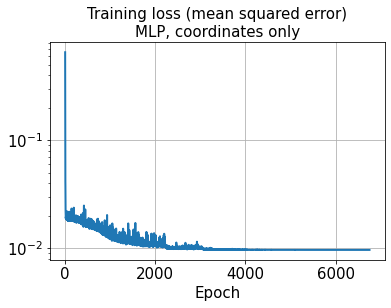

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP, coordinates only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

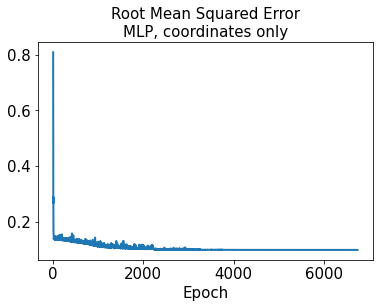

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, coordinates only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

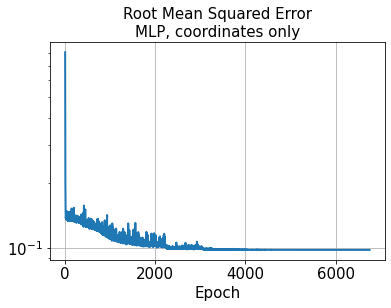

In [71]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, coordinates only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 4ms/step - loss: 0.0096 - rmse: 0.0981


In [44]:
test_results = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.0260 - rmse: 0.1613


In [45]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

2/2 [==============================] - 0s 2ms/step


In [46]:
model_name = model_directory + "\\20221124steadyValidation_MLP_test"+str(test_rate)+ "_" + str(n_units) +"units_CoordinatesOnly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
error_train_abs = np.abs(decoded_train - y_train)

In [48]:
error_test_abs = np.abs(decoded_test - y_test)

In [49]:
os.chdir(storage_dir)

In [50]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.11120818360385143


In [51]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.20405113608191383


In [52]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

0.10080965772086888


In [53]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.11122212107370234


In [54]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

0.22572336855141475


In [55]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.20402612393975697


In [56]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [57]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [58]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [59]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [60]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [61]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

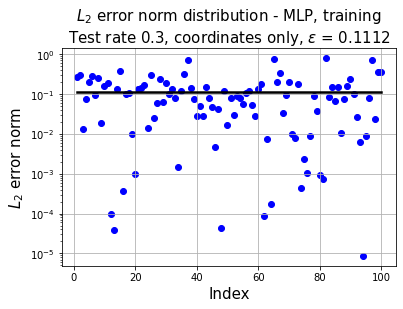

In [62]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nTest rate {0}, coordinates only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

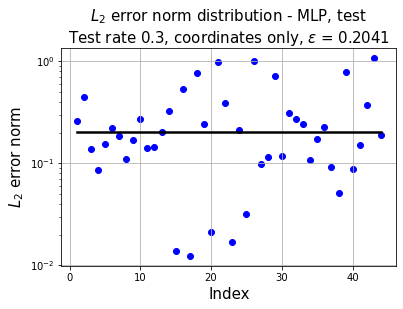

In [63]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nTest rate {0}, coordinates only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

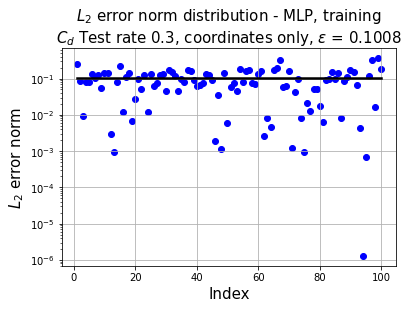

In [64]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_d$ Test rate {0}, coordinates only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

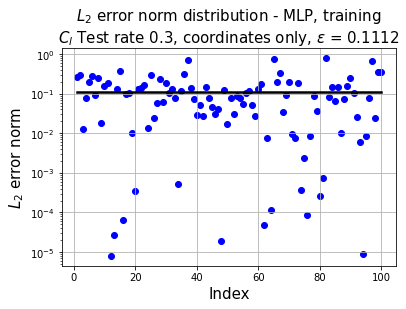

In [65]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_l$ Test rate {0}, coordinates only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

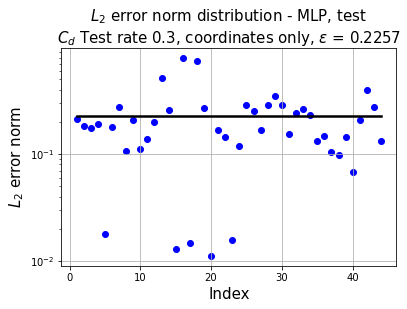

In [66]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_d$ Test rate {0}, coordinates only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

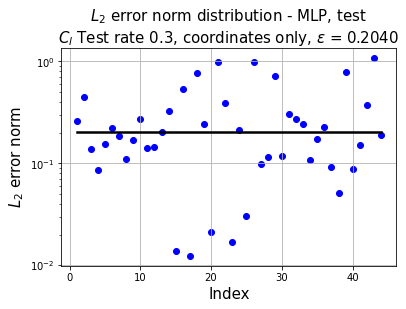

In [67]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_l$ Test rate {0}, coordinates only, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [68]:
index_train = np.unique(np.where(np.isin(y, y_train)))
index_test = np.unique(np.where(np.isin(y, y_test)))
aa = aa*np.max(alpha)

In [69]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 15ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.0611, L2 error of Cl: 0.0896


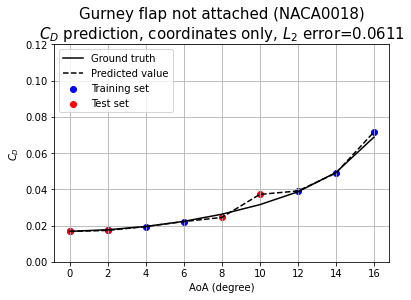

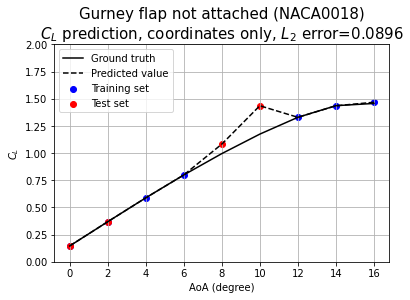

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.1942, L2 error of Cl: 0.1505


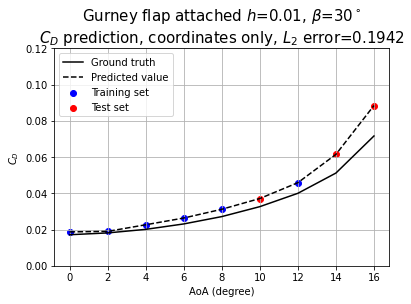

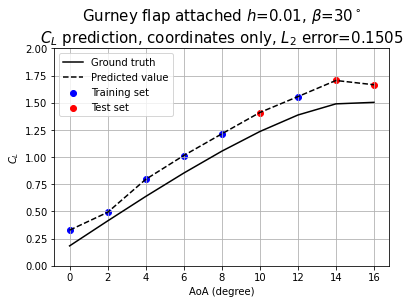

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.1624, L2 error of Cl: 0.1321


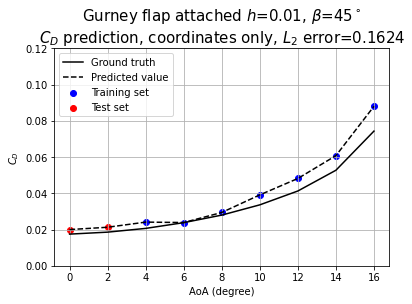

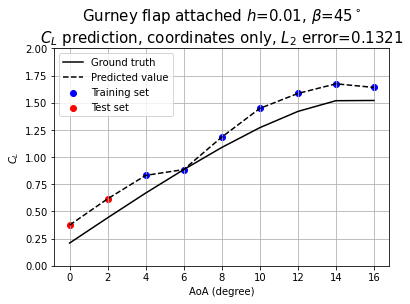

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.2704, L2 error of Cl: 0.2067


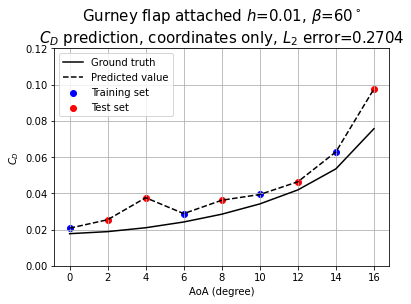

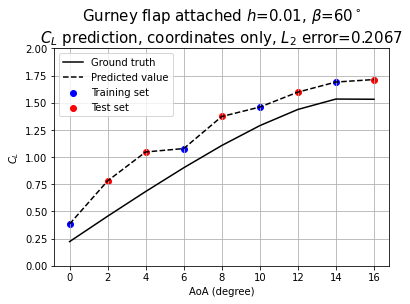

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.2487, L2 error of Cl: 0.1913


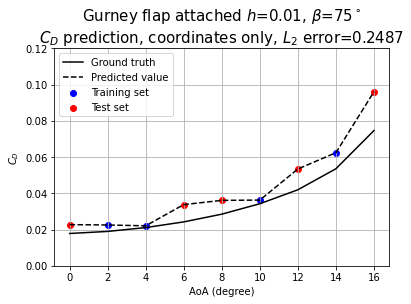

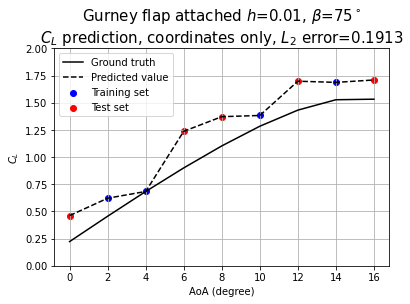

1/1 [==============================] - 0s 17ms/step
L2 error of Cd: 0.0773, L2 error of Cl: 0.1510


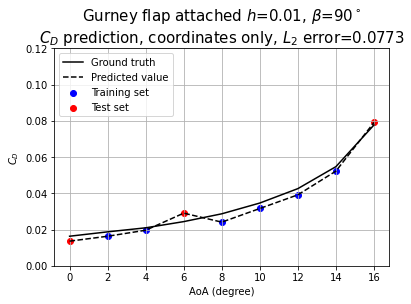

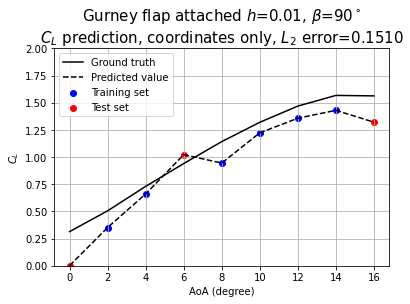

1/1 [==============================] - 0s 16ms/step
L2 error of Cd: 0.0475, L2 error of Cl: 0.0297


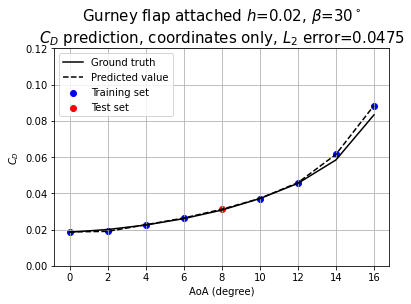

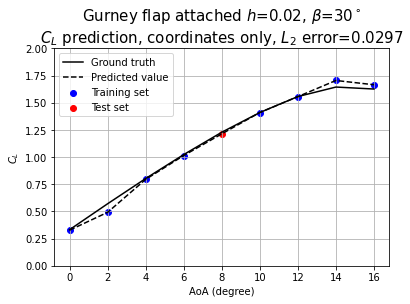

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0348, L2 error of Cl: 0.0563


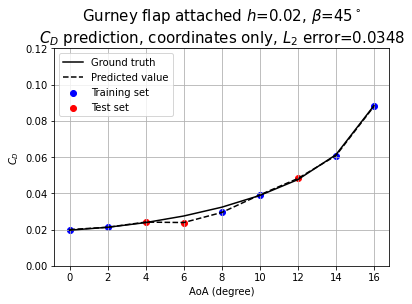

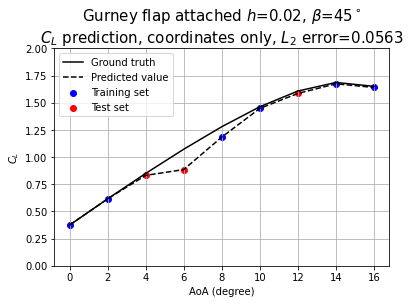

1/1 [==============================] - 0s 18ms/step
L2 error of Cd: 0.1097, L2 error of Cl: 0.0651


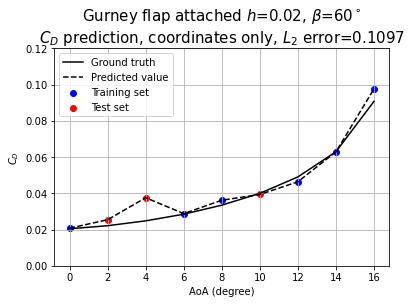

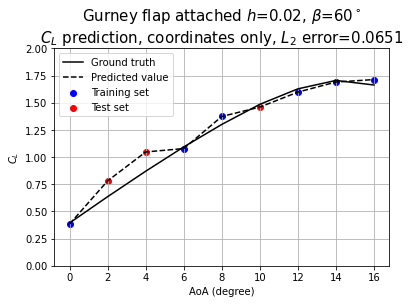

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0796, L2 error of Cl: 0.0757


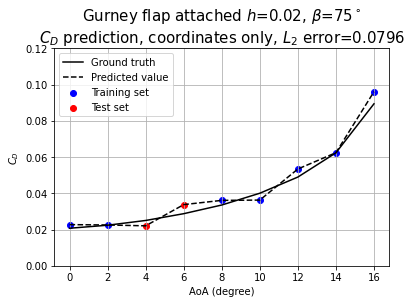

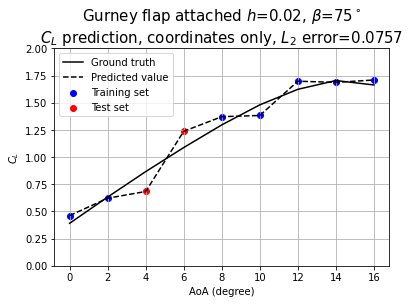

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.1260, L2 error of Cl: 0.2160


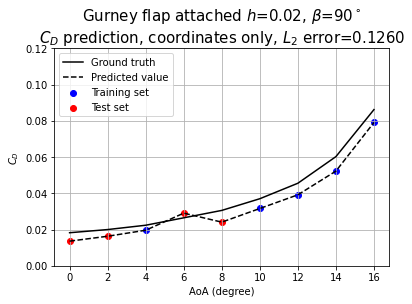

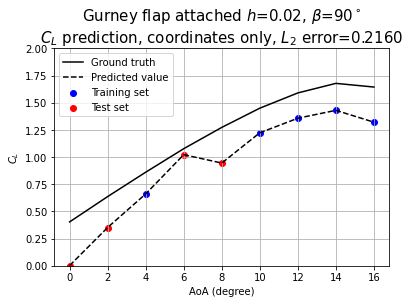

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0828, L2 error of Cl: 0.1066


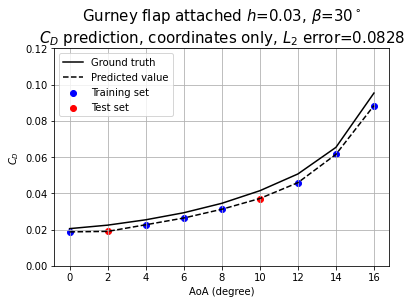

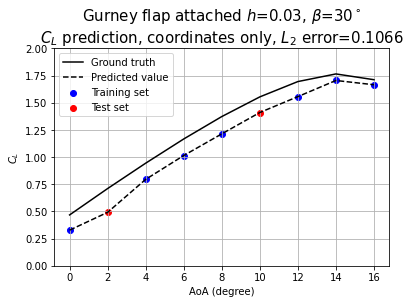

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.1361, L2 error of Cl: 0.1360


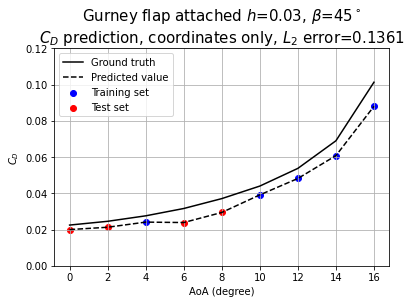

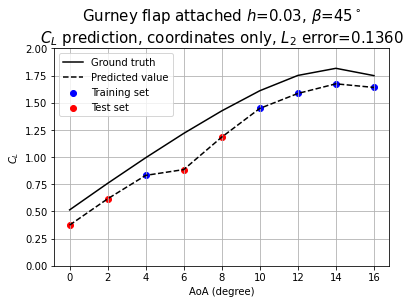

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.1169, L2 error of Cl: 0.0879


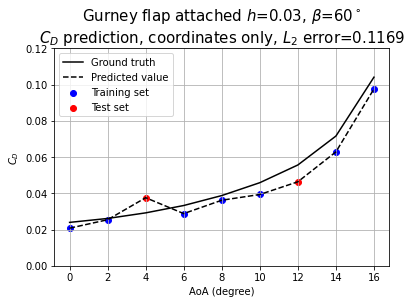

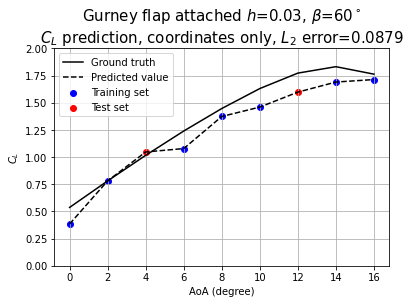

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.1083, L2 error of Cl: 0.1143


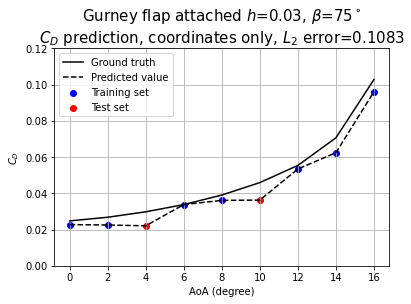

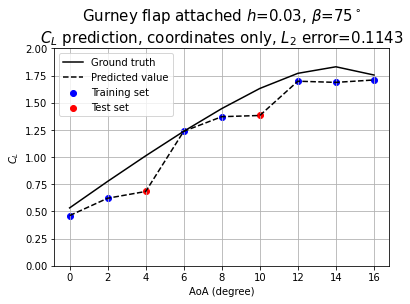

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.2242, L2 error of Cl: 0.4018


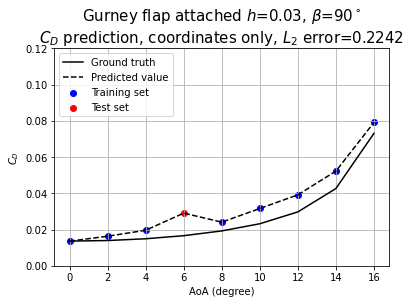

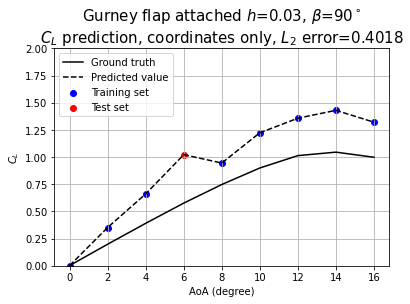

In [70]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    iTrain = []
    iTest = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue[:,1] - y_corres[:,1])**2) / np.sum(y_corres[:,1]**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    else:
        print('L2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1),1]
    cd = predicted[n_alpha*i:n_alpha*(i+1),0]
    
    CL = y[n_alpha*i:n_alpha*(i+1),1]
    CD = y[n_alpha*i:n_alpha*(i+1),0]
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])

    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)
    iTest = np.array(iTest)
    
    alpha_train = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)[:,0]
    aTest = np.array(alpha_test)[:,0]
    
    if i==0:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_D$ prediction, coordinates only, $L_2$ error=%.4f' % l2_error_Cd, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_NACA0018.jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_L$ prediction, coordinates only, $L_2$ error=%.4f' % l2_error_Cl, fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_NACA0018.jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()
    
    else:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_D$')
        plt.title('Gurney flap attached $h$=%.2f, '%h[i] +r'$\beta$=%d$^\circ$'% beta[i]+'\n$C_D$ prediction, coordinates only, $L_2$ error=%.4f'%l2_error_Cd,
                  fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()

        plt.plot(alpha, CL, 'k-', label='Ground truth')
        plt.plot(alpha, cl, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,1], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,1], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_L$')
        plt.title('Gurney flap attached $h$=%.2f, '%h[i] +r'$\beta$=%d$^\circ$'% beta[i]+'\n$C_L$ prediction, coordinates only, $L_2$ error=%.4f'%l2_error_Cl,
                  fontsize=15)
        plt.legend(loc='upper left')
        plt.ylim([0, 2])
        plt.grid()
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()